## packages

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import scipy.io as sio
import datetime
import gsw
import matplotlib.dates as mdates
import matplotlib.ticker as tick
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
from scipy.interpolate import interp1d
from scipy.interpolate import griddata
%matplotlib inline
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 100000

## Funciones

In [2]:
def to_data(date,da,s,temp):
    x = pd.DataFrame({'Datetime': pd.to_datetime(date, format='%d-%b-%Y %H:%M:%S'), 'Depth': da[:,0], 'Salinity': s[:,0], 'Temperature': temp[:,0]})
    x = x.set_index('Datetime')
    return x 

## Importar datos

In [3]:
# adcp = xr.open_dataset("C://Users//dhann//Documents//git//dump//adcp//data//adcp2012feb.nc")
adcp = xr.open_dataset("C://Users//Dhannai//Documents//git//dump//adcp//data//adcp2012feb.nc")

In [4]:
bks_drp = np.load("data/bks_drp.npy")
bks_drp1 = np.load("data/bks_drp1.npy")
bks_drp2 = np.load("data/bks_drp2.npy")
bks_drp3 = np.load("data/bks_drp3.npy")
bks_drp4 = np.load("data/bks_drp4.npy")

In [5]:
DC = sio.loadmat("C://Users//Dhannai//OneDrive//Documents//Magister//Estuario Pescadero//janmar2012//wdates_local//DC_ctds_localdates.mat")
DC_1 = to_data(DC['tdate_dc1'], DC['da_dc1'], DC['s_dc1'], DC['temp_dc1'])
dc1 = DC_1.loc[datetime.date(2012,2,17):datetime.date(2012,3,14)]

In [7]:
y_bin = np.linspace(1.19, 3.59, 25)
n_time = len(adcp.temperature)

# Obtener backscatter

In [5]:
# %script to calculate the acoustic backscatter from an
# %RDI
# % From Laurent from Alex
# %
# % this followes Deines 1999 method.  Needs to be altered re: JTECH 2010
# % paper by G....iaux and van Haren. 
#
# ​Written in Python from Matlab by Dhannai
#
# %R=cfg.ranges/(cos(pi/180*cfg.beam_angle));
R = adcp.config.ranges/(np.cos(np.pi/180*adcp.config.beam_angle))
if (adcp.config.beam_freq==1200):
  print('Using constants for 1200kHz ADCP.')
  taR=2*.48*R;    # for 1200
elif (adcp.config.beam_freq==600): 
  print('Using constants for 600kHz ADCP.')
  taR=2*.153*R;    # for 600

ldbm=10*np.log10(adcp.config.xmit_pulse)
#ldbm=10*log10(cfg.xmit_pulse);
kk_beam1 = adcp.intens.isel(beam=0)
kk_beam2 = adcp.intens.isel(beam=1)
kk_beam3 = adcp.intens.isel(beam=2)
kk_beam4 = adcp.intens.isel(beam=3)
kk=np.mean(adcp.intens,2)
bsk_beam1=0.458*(kk_beam1-40)
bsk_beam2=0.458*(kk_beam2-40)
bsk_beam3=0.458*(kk_beam3-40)
bsk_beam4=0.458*(kk_beam4-40)
bsk=0.458*(kk-40)
Sv_beam1 = np.zeros((adcp.config.n_cells, len(adcp.temperature)))
Sv_beam2 = np.zeros((adcp.config.n_cells, len(adcp.temperature)))
Sv_beam3 = np.zeros((adcp.config.n_cells, len(adcp.temperature)))
Sv_beam4 = np.zeros((adcp.config.n_cells, len(adcp.temperature)))
Sv = np.zeros((adcp.config.n_cells, len(adcp.temperature)))
for i in range(adcp.config.n_cells):
    Sv_beam1[i,:]=-139.3+10*np.log10((adcp.temperature+273.16)*R[i]**2)-ldbm-9.0+taR[i]+bsk_beam1[:,i]
    Sv_beam2[i,:]=-139.3+10*np.log10((adcp.temperature+273.16)*R[i]**2)-ldbm-9.0+taR[i]+bsk_beam2[:,i]
    Sv_beam3[i,:]=-139.3+10*np.log10((adcp.temperature+273.16)*R[i]**2)-ldbm-9.0+taR[i]+bsk_beam3[:,i]
    Sv_beam4[i,:]=-139.3+10*np.log10((adcp.temperature+273.16)*R[i]**2)-ldbm-9.0+taR[i]+bsk_beam4[:,i]
    Sv[i,:]=-139.3+10*np.log10((adcp.temperature+273.16)*R[i]**2)-ldbm-9.0+taR[i]+bsk[:,i]


Using constants for 1200kHz ADCP.


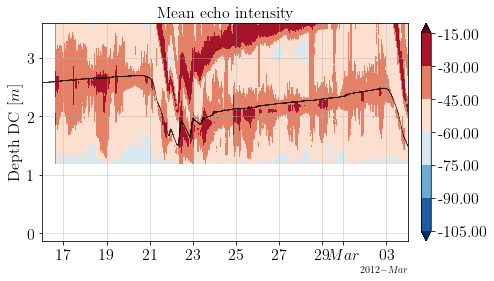

In [8]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax3) = plt.subplots(nrows=1, figsize=(8, 4))


#Grafico de velocidad del agua (color map)
ax3.set_title(r"Mean echo intensity",
          fontsize=16)
contourf_ = ax3.contourf(adcp.time, y_bin,
                         Sv,
                        #  levels=level_boundaries_v,
                         cmap=cm.RdBu_r,
                        #  vmax=vmax, vmin=vmin, 
                         extend='both')
cbar = fig.colorbar(contourf_, ax=ax3, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
ax3.plot(DC_1.index, DC_1['Depth'].values, c='k', alpha=0.8, linewidth=0.5)
ax3.set_ylabel(r"Depth DC "
          r"$\displaystyle[m]$",
          fontsize=16)
ax3.grid(alpha=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
# ax3.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
ax3.set_xlim(dtz.date(2012,2,16),dtz.date(2012,3,4))
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)


plt.show() 

# Eliminar valores

In [10]:
z = DC_1["Depth"]
Sv_new = Sv.copy()
for i in range(n_time-19):
    cont = 0
    for j in y_bin:
        if len(z.loc[adcp.time.isel(time=i).values:adcp.time.isel(time=i+19).values].values) == 0:
            i = i+1
        if z.loc[adcp.time.isel(time=i).values:adcp.time.isel(time=i+19).values].values[0] > j:
            cont+=1
        elif z.loc[adcp.time.isel(time=i).values:adcp.time.isel(time=i+19).values].values[0] <= j:
            break
    Sv_new[cont:, i] = np.nan
        

In [11]:
n_time = len(Sv_new[0,:])

In [16]:
z = DC_1["Depth"]

Sv_bks = Sv.copy()
Sv_b1 = Sv_beam1.copy()
Sv_b2 = Sv_beam2.copy()
Sv_b3 = Sv_beam3.copy()
Sv_b4 = Sv_beam4.copy()

for i in range(n_time-19):
    if len(z.loc[adcp.time.isel(time=i).values:adcp.time.isel(time=i+19).values].values) == 0:
        i = i+1
    max_height = z.loc[adcp.time.isel(time=i).values:adcp.time.isel(time=i+19).values].values[0]
    m = np.where(y_bin>=max_height)
    Sv_bks[m,i] = np.nan
    Sv_b1[m,i] = np.nan
    Sv_b2[m,i] = np.nan
    Sv_b3[m,i] = np.nan
    Sv_b4[m,i] = np.nan

In [13]:
Sv_new

array([[-106.08742174, -106.20192174, -106.54556807, ..., -106.53942632,
        -106.76886473, -106.53971859],
       [-106.04542849, -105.81642849, -105.93107482, ..., -105.92493307,
        -106.26887148, -105.92522534],
       [-106.02163796, -105.67813796, -105.67828429, ..., -105.78664255,
        -105.67258096, -105.67243481],
       ...,
       [          nan,           nan,           nan, ...,  -99.01235588,
         -98.55479429,  -98.66914815],
       [          nan,           nan,           nan, ...,  -98.45368648,
         -97.99612489,  -98.22497874],
       [          nan,           nan,           nan, ...,  -98.59497509,
         -98.0229135 ,  -97.90826736]])

In [18]:
np.save("data/bks_drp.npy", Sv_bks) 
np.save("data/bks_drp1.npy", Sv_b1) 
np.save("data/bks_drp2.npy", Sv_b2) 
np.save("data/bks_drp3.npy", Sv_b3) 
np.save("data/bks_drp4.npy", Sv_b4) 

In [7]:
max_height = DC_1["Depth"]
len(max_height)

556306

In [10]:
Sv

array([[-106.08742174, -106.20192174, -106.54556807, ...,  -46.85368976,
         -46.51003682,  -46.6243839 ],
       [-106.04542849, -105.81642849, -105.93107482, ...,  -40.62869651,
         -40.39954358,  -40.97189065],
       [-106.02163796, -105.67813796, -105.67828429, ...,  -38.88740598,
         -38.31475305,  -39.68860012],
       ...,
       [ -98.7893513 ,  -98.3313513 ,  -98.78949763, ...,  -43.10511932,
         -45.28046639,  -44.47881346],
       [ -98.34518189,  -98.11618189,  -98.34532822, ...,  -56.17194991,
         -55.02679698,  -52.16414405],
       [ -98.02847051,  -97.68497051,  -97.68511684, ...,  -62.95423853,
         -61.9235856 ,  -60.32043267]])

In [ ]:
max_height = DC_1["Depth"]
Sv_bks = Sv.copy()
Sv_b1 = Sv_beam1.copy()
Sv_b2 = Sv_beam2.copy()
Sv_b3 = Sv_beam3.copy()
Sv_b4 = Sv_beam4.copy()

for i in range(len(max_height)):
    m = np.where(y_bin>=max_height[i])

    Sv_bks[m,i] = np.nan
    Sv_b1[m,i] = np.nan
    Sv_b2[m,i] = np.nan
    Sv_b3[m,i] = np.nan
    Sv_b4[m,i] = np.nan
    


In [24]:
z.loc[adcp.time.isel(time=i).values:adcp.time.isel(time=i+19).values].values[0]

2.5920087498316007

In [26]:
z = DC_1["Depth"]
Sv_new = Sv.copy()
for i in range(100):
    cont = 0
    print("i")
    print(i)
    for j in y_bin:
        if len(z.loc[adcp.time.isel(time=i).values:adcp.time.isel(time=i+19).values].values) == 0:
            i = i+1
            print(len(z.loc[adcp.time.isel(time=i).values:adcp.time.isel(time=i+19).values].values))
        if z.loc[adcp.time.isel(time=i).values:adcp.time.isel(time=i+19).values].values[0] > j:
            cont+=1
            print(z.loc[adcp.time.isel(time=i).values:adcp.time.isel(time=i+19).values].values[0])
        elif z.loc[adcp.time.isel(time=i).values:adcp.time.isel(time=i+19).values].values[0] <= j:
            print("z")
            print(z.loc[adcp.time.isel(time=i).values:adcp.time.isel(time=i+19).values].values[0])
            print("j")
            print(j)
            break
    Sv_new[cont:, i] = np.nan
        


i
0
2.5930192996288532
2.5930192996288532
2.5930192996288532
2.5930192996288532
2.5930192996288532
2.5930192996288532
2.5930192996288532
2.5930192996288532
2.5930192996288532
2.5930192996288532
2.5930192996288532
2.5930192996288532
2.5930192996288532
2.5930192996288532
2.5930192996288532
2.5930192996288532
2.5930192996288532
z
2.5930192996288532
j
2.61
i
1
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
z
2.5920821186322605
j
2.61
i
2
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2.5920821186322605
2

# Gráficos

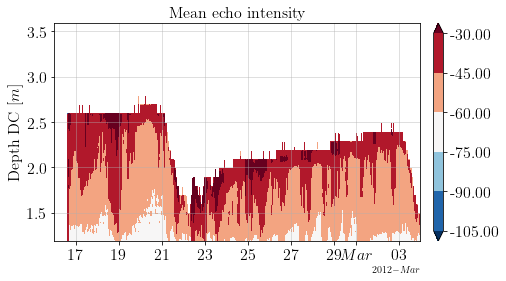

In [8]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax3) = plt.subplots(nrows=1, figsize=(8, 4))


#Grafico del backscatter (color map)
ax3.set_title(r"Mean echo intensity",
          fontsize=16)
contourf_ = ax3.contourf(adcp.time, y_bin,
                         bks_drp,
                        #  levels=level_boundaries_v,
                         cmap=cm.RdBu_r,
                        #  vmax=vmax, vmin=vmin, 
                         extend='both')
cbar = fig.colorbar(contourf_, ax=ax3, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
ax3.set_ylabel(r"Depth DC "
          r"$\displaystyle[m]$",
          fontsize=16)
ax3.grid(alpha=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
# ax3.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
ax3.set_xlim(datetime.date(2012,2,16),datetime.date(2012,3,4))
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)


plt.show() 

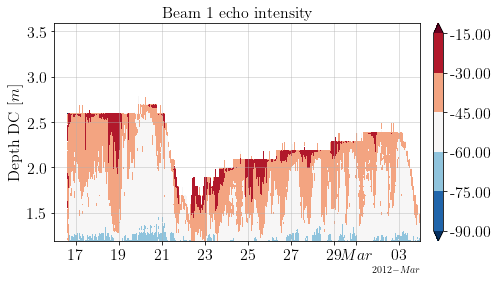

In [9]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax3) = plt.subplots(nrows=1, figsize=(8, 4))


#Grafico de velocidad del agua (color map)
ax3.set_title(r"Beam 1 echo intensity",
          fontsize=16)
contourf_ = ax3.contourf(adcp.time, y_bin,
                         bks_drp1,
                        #  levels=level_boundaries_v,
                         cmap=cm.RdBu_r,
                        #  vmax=vmax, vmin=vmin, 
                         extend='both')
cbar = fig.colorbar(contourf_, ax=ax3, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
ax3.set_ylabel(r"Depth DC "
          r"$\displaystyle[m]$",
          fontsize=16)
ax3.grid(alpha=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
# ax3.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
ax3.set_xlim(datetime.date(2012,2,16),datetime.date(2012,3,4))
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)


plt.show() 

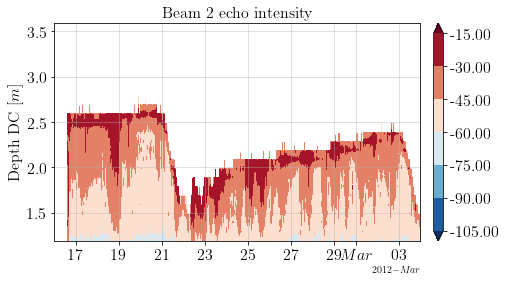

In [10]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax3) = plt.subplots(nrows=1, figsize=(8, 4))


#Grafico de velocidad del agua (color map)
ax3.set_title(r"Beam 2 echo intensity",
          fontsize=16)
contourf_ = ax3.contourf(adcp.time, y_bin,
                         bks_drp2,
                        #  levels=level_boundaries_v,
                         cmap=cm.RdBu_r,
                        #  vmax=vmax, vmin=vmin, 
                         extend='both')
cbar = fig.colorbar(contourf_, ax=ax3, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
ax3.set_ylabel(r"Depth DC "
          r"$\displaystyle[m]$",
          fontsize=16)
ax3.grid(alpha=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
# ax3.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
ax3.set_xlim(datetime.date(2012,2,16),datetime.date(2012,3,4))
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)


plt.show() 

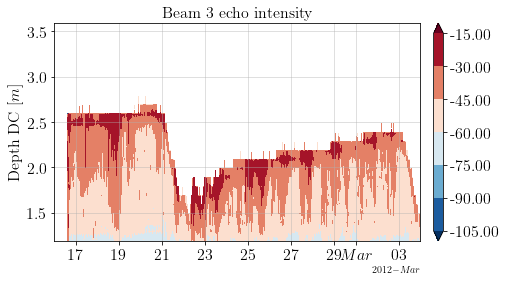

In [11]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax3) = plt.subplots(nrows=1, figsize=(8, 4))


#Grafico de velocidad del agua (color map)
ax3.set_title(r"Beam 3 echo intensity",
          fontsize=16)
contourf_ = ax3.contourf(adcp.time, y_bin,
                         bks_drp3,
                        #  levels=level_boundaries_v,
                         cmap=cm.RdBu_r,
                        #  vmax=vmax, vmin=vmin, 
                         extend='both')
cbar = fig.colorbar(contourf_, ax=ax3, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
ax3.set_ylabel(r"Depth DC "
          r"$\displaystyle[m]$",
          fontsize=16)
ax3.grid(alpha=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
# ax3.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
ax3.set_xlim(datetime.date(2012,2,16),datetime.date(2012,3,4))
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)


plt.show() 

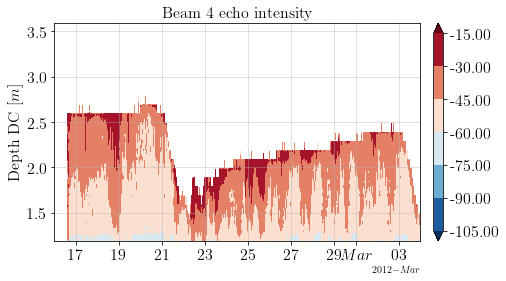

In [12]:
#Ajustar limites colorbar
umin = -0.1
umax = 0.1
vmin = -0.1
vmax = 0.1
level_boundaries_u = np.linspace(umin, umax, 400)
level_boundaries_v = np.linspace(vmin, vmax, 400)

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

#Inicio figura
fig, (ax3) = plt.subplots(nrows=1, figsize=(8, 4))


#Grafico de velocidad del agua (color map)
ax3.set_title(r"Beam 4 echo intensity",
          fontsize=16)
contourf_ = ax3.contourf(adcp.time, y_bin,
                         bks_drp4,
                        #  levels=level_boundaries_v,
                         cmap=cm.RdBu_r,
                        #  vmax=vmax, vmin=vmin, 
                         extend='both')
cbar = fig.colorbar(contourf_, ax=ax3, pad=0.03)
cbar.ax.tick_params(labelsize=16)
cbar.ax.yaxis.set_major_formatter(tick.FormatStrFormatter('%.2f'))
ax3.set_ylabel(r"Depth DC "
          r"$\displaystyle[m]$",
          fontsize=16)
ax3.grid(alpha=0.5)
ax3.xaxis.set_tick_params(labelsize=16)
ax3.yaxis.set_tick_params(labelsize=16)
# ax3.plot(dc1.index, dc1['Depth'].values, c='k', alpha=0.5, linewidth=0.5)
ax3.set_xlim(datetime.date(2012,2,16),datetime.date(2012,3,4))
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(formatter)


plt.show() 

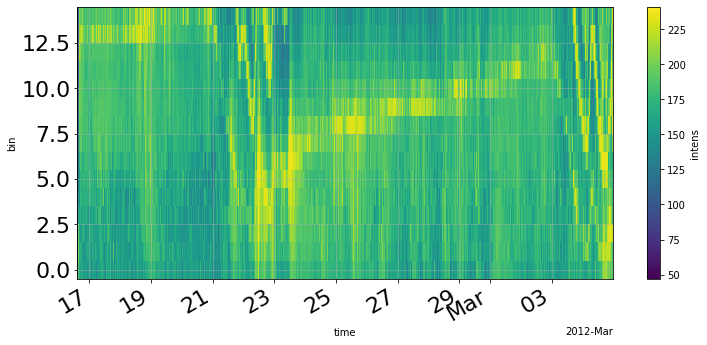

In [3]:
fig, ax = plt.subplots(nrows=1, figsize=(12, 5))

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

feb16.sel(time=slice(None,"2012-03-04"), bin=slice(None,15)).intens[:, :, 1].plot(x='time', y='bin', ax=ax)

ax.grid(alpha=0.5)
ax.xaxis.set_tick_params(labelsize=22)
ax.yaxis.set_tick_params(labelsize=22)

# Ajustar formato fecha
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

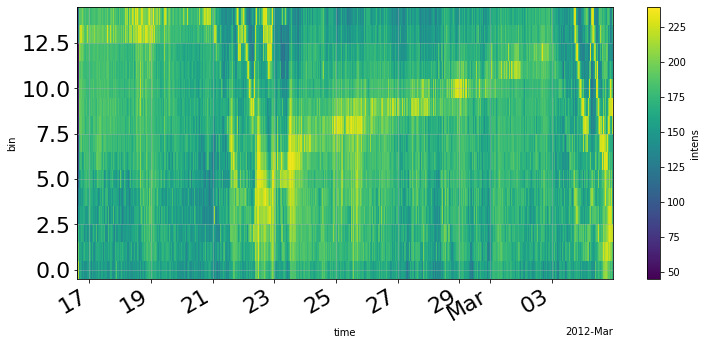

In [4]:
fig, ax = plt.subplots(nrows=1, figsize=(12, 5))

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

feb16.sel(time=slice(None,"2012-03-04"), bin=slice(None,15)).intens[:, :, 2].plot(x='time', y='bin', ax=ax)

ax.grid(alpha=0.5)
ax.xaxis.set_tick_params(labelsize=22)
ax.yaxis.set_tick_params(labelsize=22)

# Ajustar formato fecha
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

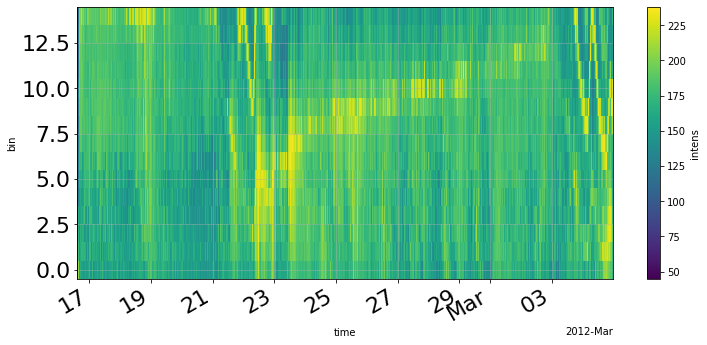

In [5]:
fig, ax = plt.subplots(nrows=1, figsize=(12, 5))

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

feb16.sel(time=slice(None,"2012-03-04"), bin=slice(None,15)).intens[:, :, 3].plot(x='time', y='bin', ax=ax)

ax.grid(alpha=0.5)
ax.xaxis.set_tick_params(labelsize=22)
ax.yaxis.set_tick_params(labelsize=22)

# Ajustar formato fecha
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

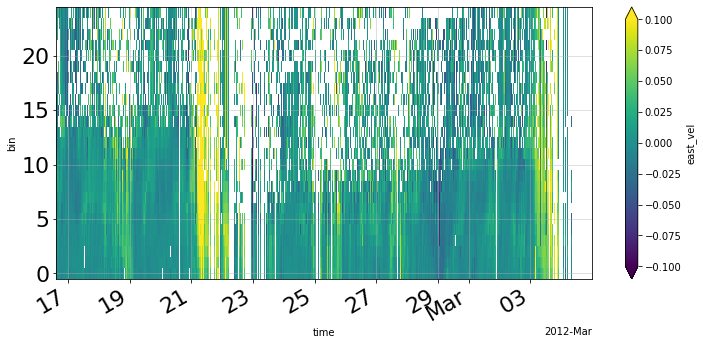

In [5]:
fig, ax = plt.subplots(nrows=1, figsize=(12, 5))

#Formato fecha
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)

contourf_ = feb16.sel(time=slice(None,"2012-03-04")).east_vel.plot(x='time', y='bin', ax=ax, vmin=-0.1, vmax=0.1)

ax.grid(alpha=0.5)
ax.xaxis.set_tick_params(labelsize=22)
ax.yaxis.set_tick_params(labelsize=22)


# Ajustar formato fecha
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

In [3]:
feb16

<xarray.Dataset>
Dimensions:       (beam: 4, bin: 25, time: 3127640)
Coordinates:
  * time          (time) datetime64[ns] 2012-02-16T14:45:00 ... 2012-03-14T18...
Dimensions without coordinates: beam, bin
Data variables: (12/30)
    east_vel      (time, bin) float64 ...
    north_vel     (time, bin) float64 ...
    vert_vel      (time, bin) float64 ...
    error_vel     (time, bin) float64 ...
    corr          (time, bin, beam) float64 ...
    status        (time, bin, beam) float64 ...
    ...            ...
    bt_corr       (time, beam) float64 ...
    bt_ampl       (time, beam) float64 ...
    bt_perc_good  (time, beam) float64 ...
    config        int32 ...
    name          object ...
    range         (bin) float64 ...
Attributes:
    src:      C://Users//vicho//Desktop//F16M5000.000